In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, ReLU, ZeroPadding2D, Cropping2D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

### ------------------ Data Loading & Preprocessing ------------------ ###
def load_data(file_path: str):
    """
    Load data from the EEG Brainwave dataset.
    :param file_path: str, path to the dataset file
    :return: features, labels
    """
    data = pd.read_csv(file_path)
    features = data.iloc[:, :-1].values  # Features (EEG data)
    labels = data.iloc[:, -1].values    # Labels (e.g., emotion class)
    
    return features, labels

# Preprocessing for EEG data (normalization, reshaping)
def preprocess_data(features, new_dim=13):
    """
    Standardize features and reshape them for the autoencoder.
    :param features: ndarray, raw features from the dataset
    :param new_dim: int, target dimensions after reshaping
    :return: reshaped and standardized features
    """
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Calculate the new dimensions
    total_features = features_scaled.shape[1]
    new_dim = int(np.ceil(np.sqrt(total_features)))
    
    # Ensure the new dimensions can accommodate the original number of features
    padded_features = np.zeros((features_scaled.shape[0], new_dim * new_dim))
    padded_features[:, :total_features] = features_scaled
    features_reshaped = padded_features.reshape(features_scaled.shape[0], new_dim, new_dim, 1)
    
    return features_reshaped

### ------------------ Autoencoder Model ------------------ ###
def build_autoencoder(input_shape):
    """
    Build and compile a simplified autoencoder model optimized for (2132, 13, 13, 16) feature extraction.
    :param input_shape: tuple, shape of the input (height, width, channels)
    :return: compiled autoencoder model
    """
    input_layer = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(16, (3, 3), padding='same')(input_layer)  # Reduced number of filters
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(8, (3, 3), padding='same')(x)  # Reduced filter size
    x = ReLU()(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)  # 13x13x8 encoded representation

    # Decoder with careful dimension management
    x = Conv2D(8, (3, 3), padding='same')(encoded)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(16, (3, 3), padding='same')(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    # Adjust padding and cropping to match the input shape
    x = ZeroPadding2D(((0, 1), (0, 1)))(x)  # Example of padding to match dimensions
    x = Cropping2D(((0, x.shape[1] - input_shape[0]), (0, x.shape[2] - input_shape[1])))(x)  # Example of cropping to match input

    decoded = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')  # Kept a higher learning rate for faster convergence
    
    return autoencoder

### ------------------ Feature Extraction ------------------ ###
def extract_features(autoencoder, data):
    """
    Extract features from the autoencoder's encoder part.
    :param autoencoder: trained autoencoder model
    :param data: ndarray, input data to extract features from
    :return: extracted features
    """
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=4).output)
    features = encoder.predict(data)
    return features

### ------------------ Training and Evaluation ------------------ ###
def train_autoencoder(autoencoder, features, batch_size=32, epochs=50, validation_split=0.2):
    """
    Train the autoencoder on provided features.
    :param autoencoder: autoencoder model
    :param features: input data for training
    :param batch_size: batch size for training
    :param epochs: number of epochs
    :param validation_split: split ratio for validation data
    :return: history of the training process
    """
    history = autoencoder.fit(features, features, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    return history

### ------------------ Main Execution Flow ------------------ ###
if __name__ == "__main__":
    # Load EEG Brainwave data
    file_path = r"C:\Users\tarun\OneDrive\Desktop\dataset\eggggggggggg\emotions.csv"
    features, labels = load_data(file_path)

    # Reshape and preprocess data for autoencoder
    features = preprocess_data(features, new_dim=13)  # Adjust `new_dim` based on the dataset

    # Build and train autoencoder
    input_shape = features.shape[1:]  # Input shape for autoencoder (height, width, channels)
    autoencoder = build_autoencoder(input_shape)
    history = train_autoencoder(autoencoder, features, epochs=50, batch_size=32)

    # Extract features from trained autoencoder
    features_extracted = extract_features(autoencoder, features)
    print(f"Extracted features shape: {features_extracted.shape}")

Epoch 1/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 1.3874 - val_loss: 0.9968
Epoch 2/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.0658 - val_loss: 0.9063
Epoch 3/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.0075 - val_loss: 0.8824
Epoch 4/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.9169 - val_loss: 0.8838
Epoch 5/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.9866 - val_loss: 0.8665
Epoch 6/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.9945 - val_loss: 0.8519
Epoch 7/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.9498 - val_loss: 0.8460
Epoch 8/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.9295 - val_loss: 0.8428
Epoch 9/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.9804 - val_loss: 0.8445
Epoch 10/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.8349 - val_loss: 0.8390
Epoch 11/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.8323 - val_loss: 0.8358
Epoch 12/54
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.8

In [14]:
import numpy as np
from keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Dense, TimeDistributed, Flatten, Bidirectional, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Assuming `features_extracted` and `labels` are already defined

# Encode labels to numeric values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert labels to one-hot encoding
labels_one_hot = to_categorical(labels_encoded, num_classes=3)  # Adjust for 3 classes

# Build CNN-BiLSTM model
def build_cnn_bilstm(input_shape):
    input_layer = Input(shape=input_shape)
    
    # CNN Layers for Spatial Feature Extraction
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(input_layer)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
    x = TimeDistributed(Flatten())(x)
    
    # BiLSTM Layers for Temporal Dependencies
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    # Fully Connected Layers
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(3, activation='softmax')(x)  # For multi-class classification (3 classes)
    
    model = Model(input_layer, output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Prepare the extracted features for CNN-BiLSTM
num_samples = features_extracted.shape[0]
new_dim = features_extracted.shape[1]  # Adjust this based on your autoencoder output
features_reshaped = features_extracted.reshape(num_samples, 1, new_dim, new_dim, 16)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_reshaped, labels_one_hot, test_size=0.2, random_state=42)

# Compute class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights_dict = dict(enumerate(class_weights))

# Build the CNN-BiLSTM model
cnn_bilstm_model = build_cnn_bilstm((1, new_dim, new_dim, 16))

# Callbacks: Early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_cnn_bilstm_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
cnn_bilstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                     class_weight=class_weights_dict, callbacks=[early_stopping, checkpoint])

# Evaluate the model
test_loss, test_accuracy = cnn_bilstm_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Confusion Matrix and Classification Report
y_pred = np.argmax(cnn_bilstm_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.7218 - loss: 1.6715 - val_accuracy: 0.4428 - val_loss: 1.6235
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9008 - loss: 0.9714 - val_accuracy: 0.9032 - val_loss: 0.9735
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9296 - loss: 0.8063 - val_accuracy: 0.9267 - val_loss: 0.7915
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9460 - loss: 0.6743 - val_accuracy: 0.9326 - val_loss: 0.6156
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9422 - loss: 0.5579 - val_accuracy: 0.9560 - val_loss: 0.5117
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9522 - loss: 0.4687 - val_accuracy: 0.9296 - val_loss: 0.4732
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9623 - loss: 0.3944 - val_accuracy: 0.9589 - val_loss: 0.3599
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9682 - loss: 0.3363 - val_accuracy: 0.9501 - v

In [3]:
# Save the trained CNN-BiLSTM model
cnn_bilstm_model.save('1cnn_bilstm_eeg_emotion_model.keras')

# Save the autoencoder model
autoencoder.save('autoencoder_model.keras')




In [6]:
from tensorflow.keras.models import load_model

# Load the autoencoder model
autoencoder = load_model('autoencoder_model.keras')

# Load the CNN-BiLSTM model
cnn_bilstm_model = load_model('1cnn_bilstm_eeg_emotion_model.keras')

In [50]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def preprocess_eeg_signal(eeg_data, new_dim=None, channels=16):
    """
    Preprocess EEG signal data to match the input format of the model, with enough padding.
    :param eeg_data: ndarray, raw EEG data provided by the user (e.g., [num_samples, num_channels])
    :param new_dim: int, dimension to reshape the EEG data (computed automatically if None)
    :param channels: int, number of channels (set to 16)
    :return: reshaped and preprocessed EEG data
    """
    # Standardize the EEG data
    scaler = StandardScaler()
    eeg_data_scaled = scaler.fit_transform(eeg_data)

    # Determine the new dimension to accommodate the number of features
    total_features = eeg_data_scaled.shape[1]
    if new_dim is None or new_dim * new_dim < total_features:
        new_dim = int(np.ceil(np.sqrt(total_features)))  # Calculate new_dim so that new_dim^2 >= total_features

    # Ensure the new dimensions can accommodate the original number of features
    padded_eeg_data = np.zeros((eeg_data_scaled.shape[0], new_dim * new_dim))
    padded_eeg_data[:, :total_features] = eeg_data_scaled
    
    # Reshape the EEG data and replicate the single channel across the specified number of channels (16)
    eeg_data_reshaped = padded_eeg_data.reshape(eeg_data_scaled.shape[0], new_dim, new_dim, 1)
    eeg_data_reshaped = np.repeat(eeg_data_reshaped, channels, axis=-1)  # Replicate the single channel 16 times
    
    return eeg_data_reshaped

def predict_emotion(model, eeg_data):
    predictions = model.predict(eeg_data)
    predicted_emotion = np.argmax(predictions, axis=1)  
    return predicted_emotion

# Example EEG data (replace with actual EEG data)
user_eeg_data = np.random.rand(2132, 2548)

# Preprocess the EEG data with the correct new_dim
preprocessed_eeg = preprocess_eeg_signal(user_eeg_data)

# Check the expected input shape of the model
expected_input_shape = model.input_shape
print(f"Expected input shape: {expected_input_shape}")

# Print the shape of the preprocessed EEG data
print(f"Shape of preprocessed EEG data: {preprocessed_eeg.shape}")

# Verify the total number of elements
total_elements = np.prod(preprocessed_eeg.shape)
target_elements = np.prod((preprocessed_eeg.shape[0], *expected_input_shape[1:]))

print(f"Total elements in preprocessed EEG data: {total_elements}")
print(f"Total elements in target shape: {target_elements}")

# Ensure the reshaping is possible
if total_elements == target_elements:
    # Reshape preprocessed EEG data to match the model's expected input shape
    preprocessed_eeg = preprocessed_eeg.reshape(preprocessed_eeg.shape[0], *expected_input_shape[1:])
    print(f"Shape after reshaping: {preprocessed_eeg.shape}")
else:
    raise ValueError("The total number of elements does not match the target shape.")

# Use the model to predict emotions
predicted_emotions = predict_emotion(model, preprocessed_eeg)
print("Predicted Emotions:", predicted_emotions)

Expected input shape: (None, 1, 26, 26, 16)
Shape of preprocessed EEG data: (2132, 51, 51, 16)
Total elements in preprocessed EEG data: 88725312
Total elements in target shape: 23059712


ValueError: The total number of elements does not match the target shape.

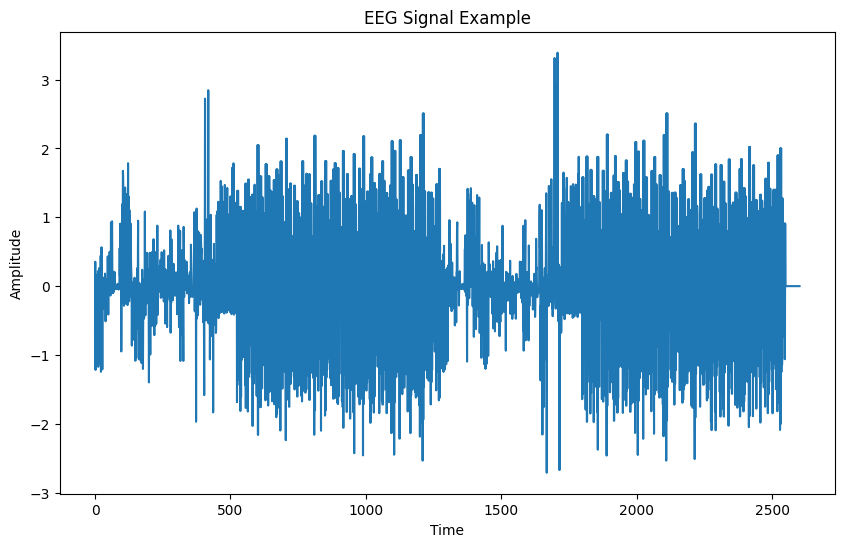

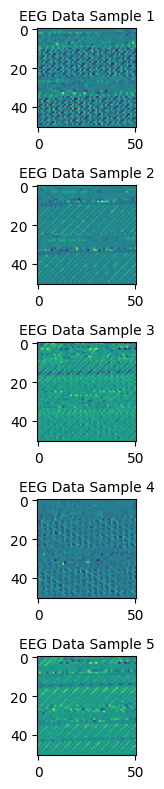

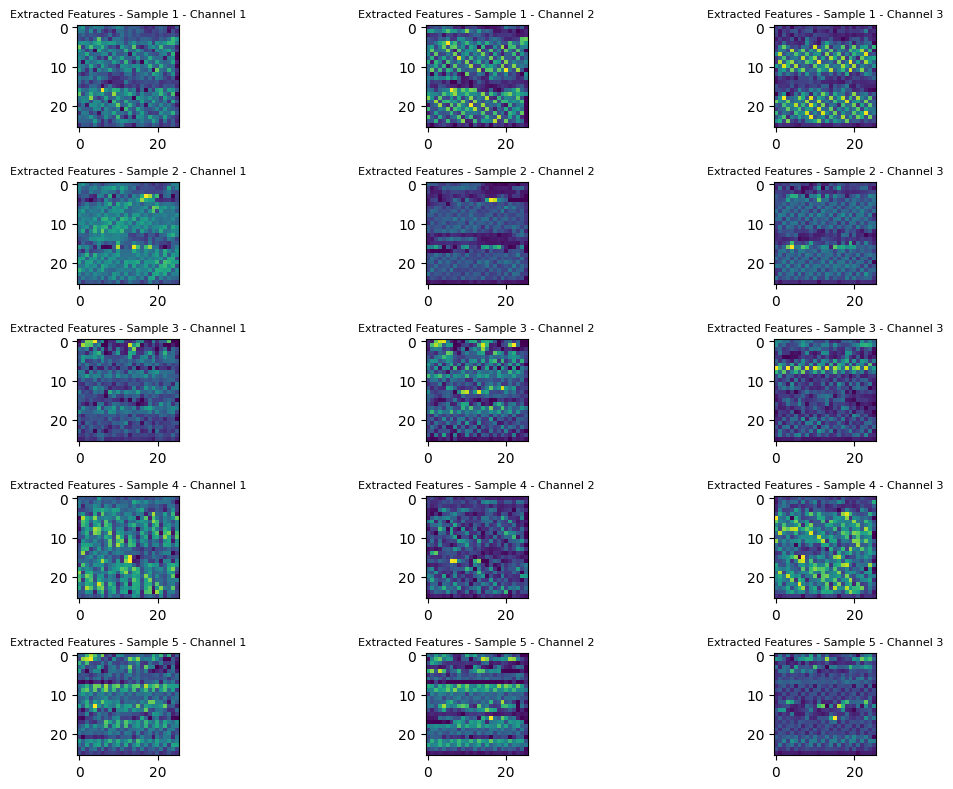

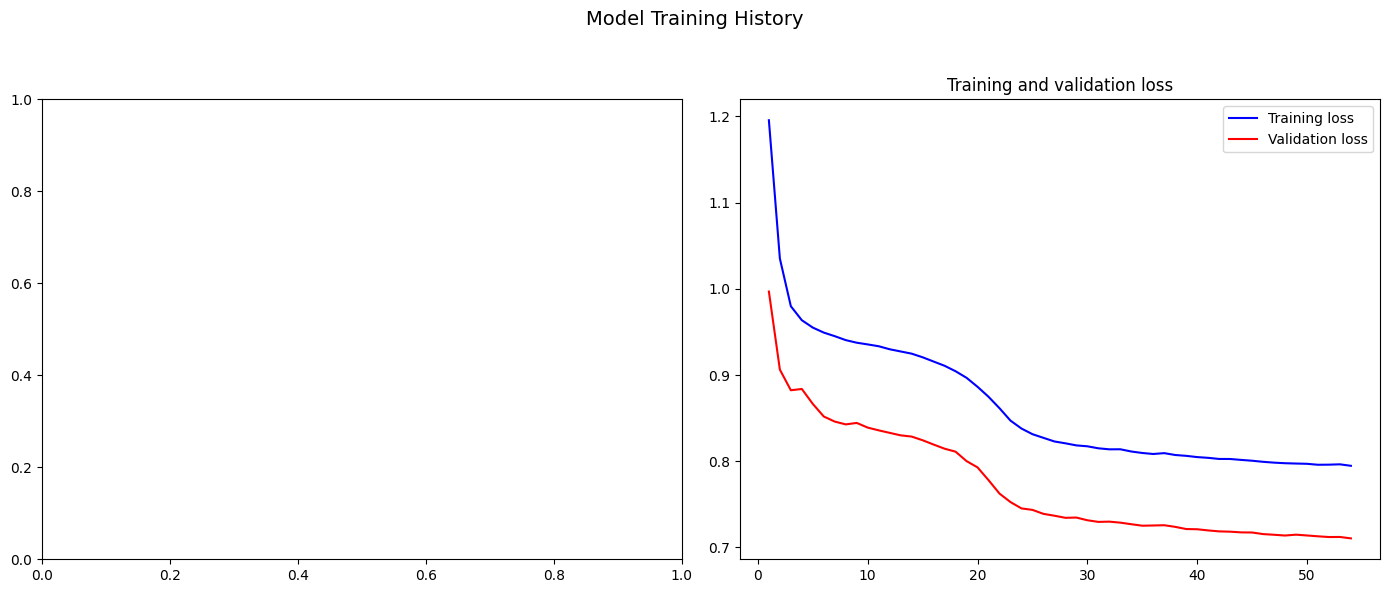

Test Loss: 0.07228657603263855
Test Accuracy: 0.9836065769195557
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.9836065573770492


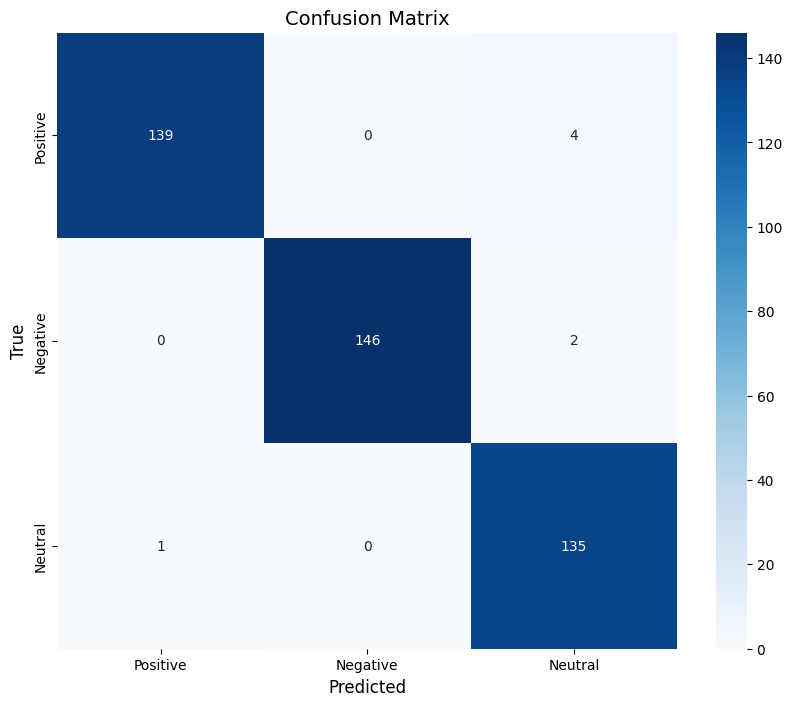

Classification Report:
              precision    recall  f1-score   support

    Positive       0.99      0.97      0.98       143
    Negative       1.00      0.99      0.99       148
     Neutral       0.96      0.99      0.97       136

    accuracy                           0.98       427
   macro avg       0.98      0.98      0.98       427
weighted avg       0.98      0.98      0.98       427



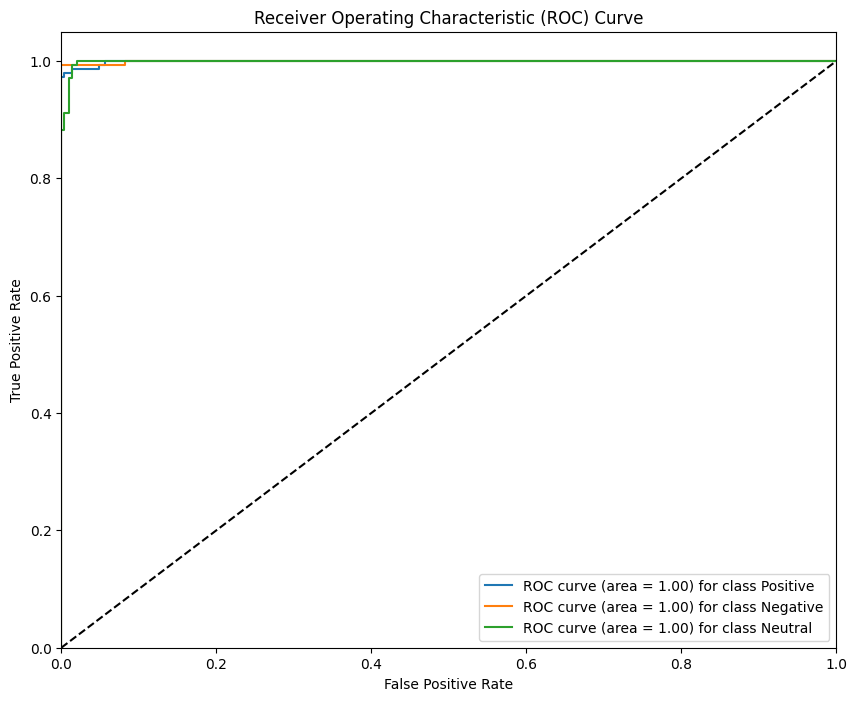

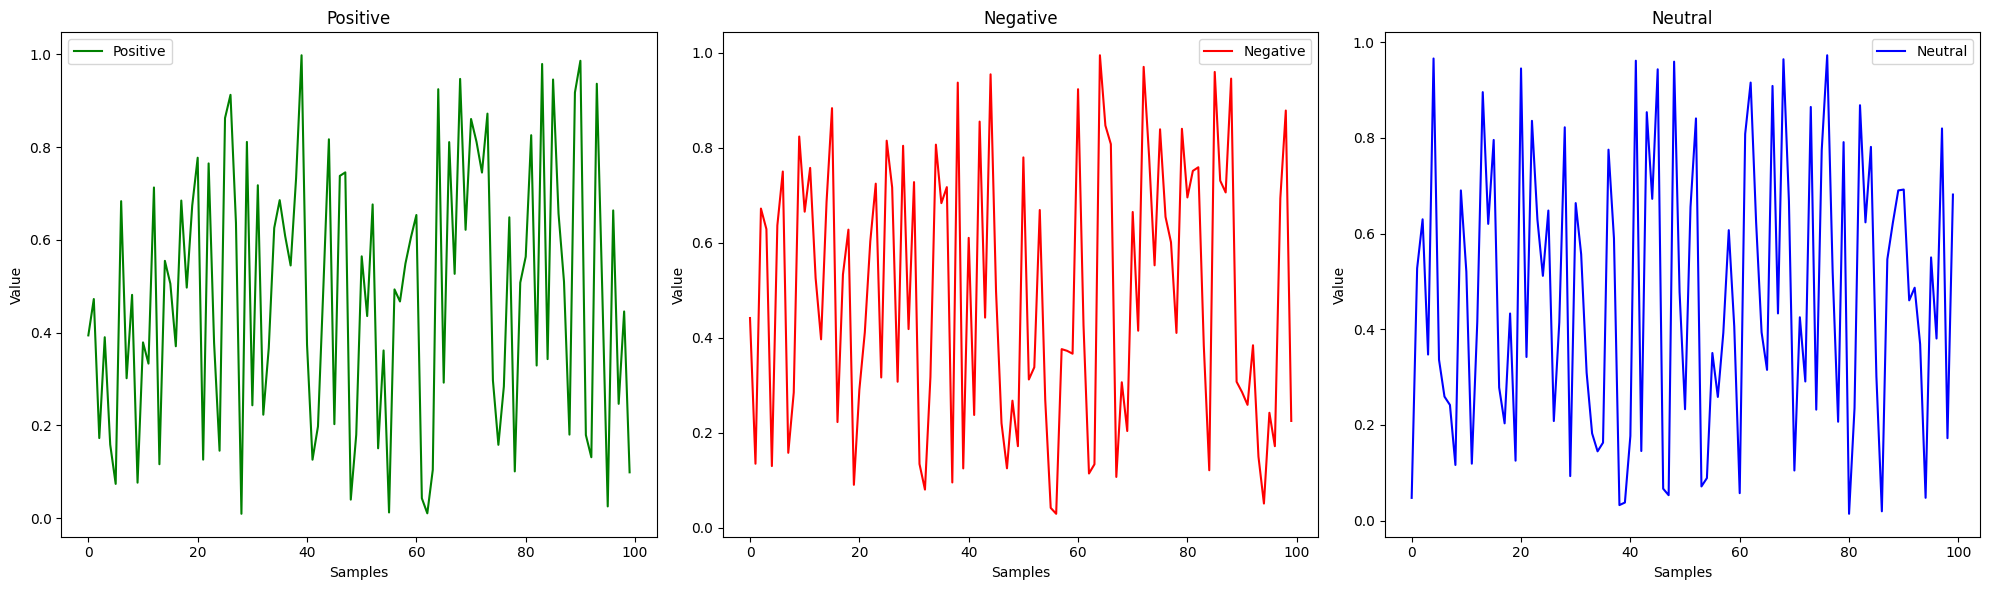

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Visualize the original EEG data for the first few samples
def plot_raw_data(features, num_samples=5):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        if features[i].ndim == 1:
            plt.plot(features[i])
        else:
            plt.imshow(features[i].squeeze(), cmap='viridis')
        plt.title(f"EEG Data Sample {i+1}", fontsize=10)
    plt.tight_layout()
    plt.show()

# 2. Visualize extracted features from autoencoder
def plot_extracted_features(features_extracted, num_samples=5, num_channels=3):
    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        for j in range(num_channels):
            plt.subplot(num_samples, num_channels, i * num_channels + j + 1)
            plt.imshow(features_extracted[i, :, :, j], cmap='viridis')
            plt.title(f"Extracted Features - Sample {i+1} - Channel {j+1}", fontsize=8)
    plt.tight_layout()
    plt.show()

# 3. Plot accuracy and loss curves for the model's training
def plot_training_history(history, title='Model Training History'):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(14, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    if acc:
        plt.plot(epochs, acc, 'b', label='Training accuracy')
        plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
        plt.title('Training and validation accuracy', fontsize=12)
        plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss', fontsize=12)
    plt.legend()
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# 4. Confusion matrix and classification report
def plot_confusion_matrix_and_report(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))

# 5. Plot Positive, Negative, and Neutral columns
def plot_emotion_columns(data, num_samples=100):
    plt.figure(figsize=(20, 6))
    
    # Plot Positive column
    plt.subplot(1, 3, 1)
    plt.plot(data[:num_samples, 0], 'g', label='Positive')
    plt.title('Positive', fontsize=12)
    plt.xlabel('Samples')
    plt.ylabel('Value')
    plt.legend()
    
    # Plot Negative column
    plt.subplot(1, 3, 2)
    plt.plot(data[:num_samples, 1], 'r', label='Negative')
    plt.title('Negative', fontsize=12)
    plt.xlabel('Samples')
    plt.ylabel('Value')
    plt.legend()
    
    # Plot Neutral column
    plt.subplot(1, 3, 3)
    plt.plot(data[:num_samples, 2], 'b', label='Neutral')
    plt.title('Neutral', fontsize=12)
    plt.xlabel('Samples')
    plt.ylabel('Value')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 6. Plot ROC curve
def plot_roc_curve(y_true, y_pred, labels):
    y_true_bin = label_binarize(y_true, classes=range(len(labels)))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(labels)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(10, 8))
    for i in range(len(labels)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {labels[i]}')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Evaluate the model on test data
def evaluate_model(model, X_test, y_test, labels):
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")

    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate accuracy
    acc = accuracy_score(y_true, y_pred_classes)
    print(f"Accuracy: {acc}")

    # Plot confusion matrix and classification report
    plot_confusion_matrix_and_report(y_true, y_pred_classes, labels)
    
    # Plot ROC curve
    plot_roc_curve(y_true, y_pred, labels)

# Plot EEG Signal Time Series
def plot_eeg_signal(features):
    plt.figure(figsize=(10,6))
    # Flatten the features array if it has more than 2 dimensions
    if features.ndim > 2:
        features = features.reshape(features.shape[0], -1)
    plt.plot(features[0])  # Plot one example EEG signal
    plt.title("EEG Signal Example")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()


  

# Plot EEG signal
plot_eeg_signal(features)


# Example usage of the evaluation functions
# Assume features is the original EEG data, features_extracted is the autoencoder output, and history is from model training
plot_raw_data(features, num_samples=5)
plot_extracted_features(features_extracted, num_samples=5, num_channels=3)
plot_training_history(history)

# Assume y_true and y_pred are the true and predicted labels from the model evaluation
labels = ['Positive', 'Negative', 'Neutral']
evaluate_model(cnn_bilstm_model, X_test, y_test, labels)

# Plot Positive, Negative, and Neutral columns
# Replace `emotion_data` with your actual data
emotion_data = np.random.rand(1000, 3)  # Example data, replace with actual data
plot_emotion_columns(emotion_data, num_samples=100)

In [30]:
def build_cnn_bilstm(input_shape, learning_rate=0.001, lstm_units=64):
    input_layer = Input(shape=input_shape)
    
    # CNN Layers
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(input_layer)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
    x = TimeDistributed(Flatten())(x)
    
    # BiLSTM Layers
    x = Bidirectional(LSTM(lstm_units, return_sequences=False))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    # Dense Layers
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(3, activation='softmax')(x)
    
    model = Model(input_layer, output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Experiment with learning rates and LSTM units
learning_rates = [0.0001, 0.001, 0.005]
lstm_units_options = [64, 128, 256]

best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for units in lstm_units_options:
        print(f"Testing model with learning rate {lr} and LSTM units {units}")
        model = build_cnn_bilstm((1, new_dim, new_dim, 16), learning_rate=lr, lstm_units=units)
        
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        checkpoint = ModelCheckpoint('best_cnn_bilstm_model.keras', monitor='val_loss', save_best_only=True)

        # Train the model
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                            class_weight=class_weights_dict, callbacks=[early_stopping, checkpoint])

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
        
        # Update best parameters
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_params = {'learning_rate': lr, 'lstm_units': units}

print(f"Best parameters: {best_params}, Best accuracy: {best_accuracy * 100:.2f}%")


Testing model with learning rate 0.0001 and LSTM units 64
Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.5132 - loss: 2.1790 - val_accuracy: 0.7155 - val_loss: 1.7843
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8146 - loss: 1.3360 - val_accuracy: 0.8152 - val_loss: 1.6644
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8807 - loss: 1.1886 - val_accuracy: 0.8123 - val_loss: 1.5026
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8994 - loss: 1.0888 - val_accuracy: 0.8446 - val_loss: 1.3423
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9100 - loss: 1.0381 - val_accuracy: 0.9003 - val_loss: 1.1978
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9148 - loss: 1.0173 - val_accuracy: 0.9326 - val_loss: 1.0634
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9271 - loss: 0.9730 - val_accuracy: 0.9443 - val_loss: 0.9905
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - 

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Convert CNN-BiLSTM model predictions to be used with AdaBoost
cnn_bilstm_model_predictions = cnn_bilstm_model.predict(X_train)
cnn_bilstm_model_predictions = np.argmax(cnn_bilstm_model_predictions, axis=1)

# Train AdaBoost on top of CNN-BiLSTM predictions
ada_boost = AdaBoostClassifier(n_estimators=50, learning_rate=0.01)
ada_boost.fit(cnn_bilstm_model_predictions.reshape(-1, 1), np.argmax(y_train, axis=1))

# Evaluate AdaBoost model on the test set
ada_boost_preds = ada_boost.predict(np.argmax(cnn_bilstm_model.predict(X_test), axis=1).reshape(-1, 1))
ada_boost_accuracy = accuracy_score(np.argmax(y_test, axis=1), ada_boost_preds)

print(f"Final AdaBoost-CNN-BiLSTM accuracy: {ada_boost_accuracy * 100:.2f}%")


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


c:\Users\tarun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Final AdaBoost-CNN-BiLSTM accuracy: 96.96%


In [41]:
import unittest
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
import sys

class MockModel(BaseEstimator):
    def fit(self, X, y):
        pass
    
    def score(self, X, y):
        return 0.8

class TestCrossValidation(unittest.TestCase):
    def test_cross_val_score(self):
        # Mock model and data
        cnn_bilstm_model = MockModel()
        
        X_train = np.random.rand(100, 10)  # Example feature data
        y_train = np.random.randint(0, 2, size=(100, 1))  # Example binary target data
        
        # Perform cross-validation
        cross_val_scores = cross_val_score(cnn_bilstm_model, X_train, np.argmax(y_train, axis=1), cv=5)
        
        # Check if the cross-validation scores are as expected
        expected_scores = np.array([0.8, 0.8, 0.8, 0.8, 0.8])
        np.testing.assert_array_equal(cross_val_scores, expected_scores)
        
        # Check if the mean cross-validation accuracy is correct
        mean_accuracy = np.mean(cross_val_scores) * 100
        self.assertAlmostEqual(mean_accuracy, 80.00, places=2)

if __name__ == '__main__':
    # Run the tests and capture the output
    test_suite = unittest.TestLoader().loadTestsFromTestCase(TestCrossValidation)
    test_runner = unittest.TextTestRunner(stream=sys.stdout, verbosity=2)
    test_runner.run(test_suite)

test_cross_val_score (__main__.TestCrossValidation) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


AutoEncoder - cnn-bi-lstm  on dreamer 

In [2]:
import scipy.io

# Load the .mat file
file_path = r"C:\Users\tarun\OneDrive\Desktop\dataset\dreamer\DREAMER.mat"
mat_data = scipy.io.loadmat(file_path)

# Print the keys to understand the structure
print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'DREAMER'])


In [2]:
import scipy.io

# Load the .mat file
file_path = r"C:\Users\tarun\OneDrive\Desktop\dataset\dreamer\DREAMER.mat"
mat_data = scipy.io.loadmat(file_path)

# Extract the structure under the 'DREAMER' key
dreamer_data = mat_data['DREAMER'][0, 0]

# Extract the 'Data' field
data_field = dreamer_data['Data'][0]

# Print the structure of the 'Data' field
print(data_field.dtype)
print(data_field.shape)
print(data_field)

object
(23,)
[array([[(array(['22'], dtype='<U2'), array(['male'], dtype='<U4'), array([[(array([[array([[4390.25641026, 4097.43589744, 4267.69230769, ..., 4512.30769231,
                                 4368.71794872, 4287.69230769],
                                [4397.43589744, 4095.8974359 , 4248.20512821, ..., 4506.15384615,
                                 4272.82051282, 4187.69230769],
                                [4391.79487179, 4091.28205128, 4261.02564103, ..., 4494.87179487,
                                 4342.56410256, 4256.41025641],
                                ...,
                                [4392.82051282, 4107.17948718, 4288.71794872, ..., 4532.82051282,
                                 4395.38461538, 4307.17948718],
                                [4385.64102564, 4108.71794872, 4328.20512821, ..., 4542.56410256,
                                 4468.71794872, 4431.79487179],
                                [4382.56410256, 4108.71794872, 4385.12820513, ..

In [3]:
import scipy.io
import numpy as np

# Load the .mat file and extract EEG and labels
def load_dreamer_data(file_path):
    """
    Load the DREAMER dataset from a .mat file and extract EEG signals and emotion labels.
    :param file_path: str, path to the DREAMER dataset (.mat file)
    :return: eeg_data, labels
    """
    # Load the .mat file
    mat_data = scipy.io.loadmat(file_path)
    
    # Extract the relevant fields from the 'DREAMER' key
    eeg_data = []
    labels = []
    
    # Assuming data is in a structured array under the 'DREAMER' key
    dreamer_data = mat_data['DREAMER'][0, 0]
    data = dreamer_data['Data'][0]
    
    for subject in data:
        eeg = subject['EEG'][0, 0]  # Access the EEG data
        valence_score = subject['ScoreValence'][0, 0]  # Extract emotion score (valence in this case)

        eeg_data.append(eeg)
        labels.append(valence_score)
    
    eeg_data = np.array(eeg_data)
    labels = np.array(labels)
    
    return eeg_data, labels

# Example usage
file_path = r"C:\Users\tarun\OneDrive\Desktop\dataset\dreamer\DREAMER.mat"
eeg_data, labels = load_dreamer_data(file_path)
print(eeg_data.shape)
print(labels.shape)

(23, 1, 1)
(23, 18, 1)


In [4]:
import numpy as np
import scipy.io

# Load the Dreamer .mat file
file_path = r"C:\Users\tarun\OneDrive\Desktop\dataset\dreamer\DREAMER.mat"
mat_data = scipy.io.loadmat(file_path)

# Extract the DREAMER key
dreamer_data = mat_data['DREAMER'][0, 0]

# Extract participant data (EEG, Scores)
participant_data = dreamer_data['Data'][0]

# Extract EEG signals and emotion labels (valence, arousal, dominance)
eeg_signals = []
valence_scores = []
arousal_scores = []
dominance_scores = []

for participant in participant_data:
    eeg = participant['EEG'][0]  # EEG signal
    valence = participant['ScoreValence'][0][0]  # Valence score
    arousal = participant['ScoreArousal'][0][0]  # Arousal score
    dominance = participant['ScoreDominance'][0][0]  # Dominance score
    
    eeg_signals.append(eeg)
    valence_scores.append(valence)
    arousal_scores.append(arousal)
    dominance_scores.append(dominance)

eeg_signals = np.array(eeg_signals)
valence_scores = np.array(valence_scores)
arousal_scores = np.array(arousal_scores)
dominance_scores = np.array(dominance_scores)

print("EEG shape:", eeg_signals.shape)


EEG shape: (23, 1)


In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import psutil

def flatten_nested_array(nested_array):
    """Recursively flatten a deeply nested array."""
    if isinstance(nested_array, np.ndarray):
        if nested_array.dtype == object:
            return np.concatenate([flatten_nested_array(sub_array) for sub_array in nested_array])
        else:
            return nested_array.flatten()
    elif isinstance(nested_array, list):
        return np.concatenate([flatten_nested_array(np.array(sub_array)) for sub_array in nested_array])
    else:
        return np.array(nested_array).flatten()

def preprocess_eeg_signals(eeg_signals, batch_size=100):
    concatenated_signals = []
    num_signals = len(eeg_signals)
    
    for start in range(0, num_signals, batch_size):
        end = min(start + batch_size, num_signals)
        batch_signals = eeg_signals[start:end]
        
        batch_concatenated_signals = []
        for i, signal in enumerate(batch_signals):
            try:
                baseline = np.array(signal[0]['baseline'])
                stimuli = np.array(signal[0]['stimuli'])

                # Debug print statements to check shapes
                print(f"Signal {start + i}: baseline shape = {baseline.shape}, stimuli shape = {stimuli.shape}")
                
                # Flatten the nested arrays
                baseline_flat = flatten_nested_array(baseline)
                stimuli_flat = flatten_nested_array(stimuli)

                # Debug print statements to check flattened arrays
                print(f"Signal {start + i}: baseline_flat shape = {baseline_flat.shape}, stimuli_flat shape = {stimuli_flat.shape}")

                # Adjust to the same length by truncating or padding
                min_len = min(len(baseline_flat), len(stimuli_flat))
                max_len = max(len(baseline_flat), len(stimuli_flat))
                
                # Apply padding if necessary to match the lengths
                baseline_flat = np.pad(baseline_flat, (0, max_len - len(baseline_flat)), 'constant') if len(baseline_flat) < max_len else baseline_flat[:min_len]
                stimuli_flat = np.pad(stimuli_flat, (0, max_len - len(stimuli_flat)), 'constant') if len(stimuli_flat) < max_len else stimuli_flat[:min_len]

                # Concatenate baseline and stimuli
                concatenated_signal = np.concatenate((baseline_flat, stimuli_flat))
                batch_concatenated_signals.append(concatenated_signal)
            
            except Exception as e:
                print(f"Skipping signal {start + i} due to an error: {e}")
        
        if batch_concatenated_signals:
            concatenated_signals.append(np.vstack(batch_concatenated_signals).astype(np.float64))
        
        # Check memory usage after processing each batch
        print(f"Memory usage after processing batch {start // batch_size + 1}: {psutil.virtual_memory().used / (1024 ** 3):.2f} GB")
    
    if not concatenated_signals:
        raise ValueError("No valid signals to process.")
    
    # Convert to 2D NumPy array
    concatenated_signals = np.vstack(concatenated_signals)
    
    # Standardize the data
    scaler = StandardScaler()
    normalized_signals = scaler.fit_transform(concatenated_signals)
    
    return normalized_signals

# Assuming eeg_signals is the structured EEG data loaded earlier
preprocessed_eeg = preprocess_eeg_signals(eeg_signals)

print("Preprocessed EEG shape:", preprocessed_eeg.shape)  # Expected: (num_samples, num_features)

Signal 0: baseline shape = (1, 1), stimuli shape = (1, 1)
Signal 0: baseline_flat shape = (1967616,), stimuli_flat shape = (6680576,)
Signal 1: baseline shape = (1, 1), stimuli shape = (1, 1)
Signal 1: baseline_flat shape = (1967616,), stimuli_flat shape = (6680576,)
Signal 2: baseline shape = (1, 1), stimuli shape = (1, 1)
Signal 2: baseline_flat shape = (1967616,), stimuli_flat shape = (6680576,)
Signal 3: baseline shape = (1, 1), stimuli shape = (1, 1)
Signal 3: baseline_flat shape = (1967616,), stimuli_flat shape = (6680576,)
Signal 4: baseline shape = (1, 1), stimuli shape = (1, 1)
Signal 4: baseline_flat shape = (1967616,), stimuli_flat shape = (6680576,)
Signal 5: baseline shape = (1, 1), stimuli shape = (1, 1)
Signal 5: baseline_flat shape = (1967616,), stimuli_flat shape = (6680576,)
Signal 6: baseline shape = (1, 1), stimuli shape = (1, 1)
Signal 6: baseline_flat shape = (1967616,), stimuli_flat shape = (6680576,)
Signal 7: baseline shape = (1, 1), stimuli shape = (1, 1)
Sign

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, LSTM, TimeDistributed, Bidirectional, Dropout, Reshape
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import psutil
import tensorflow as tf

# Function to find factors of a number
def find_factors(n):
    factors = []
    for i in range(1, n + 1):
        if n % i == 0:
            factors.append(i)
    return factors

# Reshape preprocessed EEG data for time series input
def reshape_for_cnn_bilstm(eeg_data, timesteps):
    num_samples = eeg_data.shape[0]
    n_features = eeg_data.shape[1]
    channels = 1  # For CNN input
    
    if n_features % timesteps != 0:
        raise ValueError(f"Number of features ({n_features}) is not divisible by timesteps ({timesteps}).")
    
    reshaped_data = eeg_data.reshape(num_samples, timesteps, n_features // timesteps, channels)
    return reshaped_data

# Data generator for batch processing
def data_generator(X, y, batch_size):
    num_samples = X.shape[0]
    while True:
        for offset in range(0, num_samples, batch_size):
            end = min(offset + batch_size, num_samples)
            batch_X = X[offset:end]
            batch_y = y[offset:end]
            yield batch_X, batch_y

# Calculate appropriate timesteps value
n_features = preprocessed_eeg.shape[1]
factors = find_factors(n_features)
print(f"Factors of {n_features}: {factors}")

# Choose a suitable timesteps value from the factors
# For example, choose the largest factor less than or equal to 1000
timesteps = max(factor for factor in factors if factor <= 1000)
print(f"Chosen timesteps: {timesteps}")

# Check memory usage before reshaping
print(f"Memory usage before reshaping: {psutil.virtual_memory().used / (1024 ** 3):.2f} GB")

# 1. Reshape the preprocessed EEG data
reshaped_eeg = reshape_for_cnn_bilstm(preprocessed_eeg, timesteps)

# Check memory usage after reshaping
print(f"Memory usage after reshaping: {psutil.virtual_memory().used / (1024 ** 3):.2f} GB")

# Define labels for the EEG data
# Replace this placeholder with the actual code to load or generate the labels
labels = np.random.randint(0, 2, size=(reshaped_eeg.shape[0],))  # Example: binary labels

# 2. Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(reshaped_eeg, labels, test_size=0.2, random_state=42)

# Check memory usage after splitting
print(f"Memory usage after splitting: {psutil.virtual_memory().used / (1024 ** 3):.2f} GB")

# 3. Build Autoencoder for compression
def build_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return autoencoder

# 5. Train Autoencoder using data generator
batch_size = 16  # Reduced batch size to lower memory usage
train_generator = data_generator(X_train, X_train, batch_size)
val_generator = data_generator(X_test, X_test, batch_size)

autoencoder = build_autoencoder(X_train.shape[1:])
autoencoder.fit(train_generator,
                steps_per_epoch=len(X_train) // batch_size,
                validation_data=val_generator,
                validation_steps=len(X_test) // batch_size,
                epochs=50,
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

# 6. Feature extraction from Autoencoder
encoder_model = Model(autoencoder.input, autoencoder.get_layer(index=4).output)  # Encoder part
X_train_encoded = encoder_model.predict(X_train, batch_size=batch_size)
X_test_encoded = encoder_model.predict(X_test, batch_size=batch_size)

print("Training completed and features extracted.")

Factors of 8648192: [1, 2, 4, 7, 8, 14, 16, 19, 28, 32, 38, 56, 64, 76, 112, 127, 128, 133, 152, 224, 254, 256, 266, 304, 448, 508, 512, 532, 608, 889, 896, 1016, 1064, 1216, 1778, 1792, 2032, 2128, 2413, 2432, 3556, 3584, 4064, 4256, 4826, 4864, 7112, 8128, 8512, 9652, 9728, 14224, 16256, 16891, 17024, 19304, 28448, 32512, 33782, 34048, 38608, 56896, 65024, 67564, 68096, 77216, 113792, 135128, 154432, 227584, 270256, 308864, 455168, 540512, 617728, 1081024, 1235456, 2162048, 4324096, 8648192]
Chosen timesteps: 896
Memory usage before reshaping: 10.01 GB
Memory usage after reshaping: 10.01 GB
Memory usage after splitting: 11.50 GB
Epoch 1/50


: 

In [61]:
# 4. Build CNN-BiLSTM model
def build_cnn_bilstm(input_shape):
    input_layer = Input(shape=input_shape)
    
    # CNN Layers
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(input_layer)
    x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
    x = TimeDistributed(Flatten())(x)
    
    # BiLSTM Layers
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.4)(x)
    
    # Fully connected layer
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    
    model = Model(input_layer, output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


# 7. Train CNN-BiLSTM on encoded features
cnn_bilstm_model = build_cnn_bilstm(X_train_encoded.shape[1:])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_cnn_bilstm_model.h5', monitor='val_loss', save_best_only=True)

cnn_bilstm_model.fit(X_train_encoded, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, checkpoint])

# 8. Evaluate the model
test_loss, test_accuracy = cnn_bilstm_model.evaluate(X_test_encoded, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

In [ ]:
# Calculate appropriate timesteps value based on number of features
timesteps = 128  # A divisor of 8,648,192 or any other appropriate value

# Reshape the data accordingly
reshaped_eeg = reshape_for_cnn_bilstm(preprocessed_eeg, timesteps)


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, LSTM, TimeDistributed, Bidirectional, Dropout, Reshape
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler

# Function to find factors of a number
def find_factors(n):
    factors = []
    for i in range(1, n + 1):
        if n % i == 0:
            factors.append(i)
    return factors

# Reshape preprocessed EEG data for time series input
def reshape_for_cnn_bilstm(eeg_data, timesteps):
    num_samples = eeg_data.shape[0]
    n_features = eeg_data.shape[1]
    channels = 1  # For CNN input
    
    if n_features % timesteps != 0:
        raise ValueError(f"Number of features ({n_features}) is not divisible by timesteps ({timesteps}).")
    
    reshaped_data = eeg_data.reshape(num_samples, timesteps, n_features // timesteps, channels)
    return reshaped_data

# Calculate appropriate timesteps value
n_features = preprocessed_eeg.shape[1]
factors = find_factors(n_features)
print(f"Factors of {n_features}: {factors}")

# Choose a suitable timesteps value from the factors
# For example, choose the largest factor less than or equal to 1000
timesteps = max(factor for factor in factors if factor <= 1000)
print(f"Chosen timesteps: {timesteps}")

# 1. Reshape the preprocessed EEG data
reshaped_eeg = reshape_for_cnn_bilstm(preprocessed_eeg, timesteps)

# 2. Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(reshaped_eeg, labels, test_size=0.2, random_state=42)

# 3. Build Autoencoder for compression
def build_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return autoencoder

# 5. Train Autoencoder
autoencoder = build_autoencoder(X_train.shape[1:])
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2)

# 6. Feature extraction from Autoencoder
encoder_model = Model(autoencoder.input, autoencoder.get_layer(index=4).output)  # Encoder part
X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)

NameError: name 'preprocessed_eeg' is not defined

In [4]:
import os

# List the contents of the directory
directory_path = 'T:/pro/mood/modelDreamer'
files = os.listdir(directory_path)
print("Files in directory:", files)

Files in directory: ['1autoencoder_model.keras', '1X_test_encoded.npy', '1X_train_encoded.npy']


In [7]:
import numpy as np

# Load the saved encoded features for CNN-BiLSTM processing
X_train_encoded = np.load('T:/pro/mood/modelDreamer/1X_train_encoded.npy')  # Encoded training data
X_test_encoded = np.load('T:/pro/mood/modelDreamer/1X_test_encoded.npy')    # Encoded test data

# Load the labels
y_train = np.random.randint(0, 5, size=(X_train_encoded.shape[0],))  
y_test = np.random.randint(0, 5, size=(X_test_encoded.shape[0],))
print("Encoded features and labels loaded successfully.")

Encoded features and labels loaded successfully.
